In [1031]:
#Import Tools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import openpyxl

In [1032]:
# Gives adjacency dictionary (not mine)
edge_dict={}
def create_edge_dict(graph):
    for i, n in G.adjacency():
        # print("i is",i)
        # print("n is",n)
        edge_dict[i] = list(n)
    return edge_dict

# Gives duplicate items in a list (not mine)
def list_duplicates(seq):
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )


#(https://www.geeksforgeeks.org/python-merge-two-lists-into-list-of-tuples/)
def merge(list1, list2):
      
    merged_list = []
    for i in range(max((len(list1), len(list2)))):
  
        while True:
            try:
                tup = (list1[i], list2[i])
            except IndexError:
                if len(list1) > len(list2):
                    list2.append('')
                    tup = (list1[i], list2[i])
                elif len(list1) < len(list2):
                    list1.append('')
                    tup = (list1[i], list2[i])
                continue
  
            merged_list.append(tup)
            break
    return merged_list


# function to check whether the list is empty or not
def is_list_empty(list):
    # checking the length
    if len(list) == 0:
        # returning true as length is 0
        return True
    # returning false as length is greater than 0
    return False

In [1033]:
# #retrieve data regarding vacant spaces
from openpyxl import load_workbook
workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

# #create dictionary based on excel worksheet
vacant_spaces={}
for value in sheet1.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        vacant_spaces[value[0]]={}
        vacant_spaces[value[0]]["location"]=value[1]
        vacant_spaces[value[0]]["tag"]=value[6]
        vacant_spaces[value[0]]["building"]=value[3]
        vacant_spaces[value[0]]["size_real"]=int(value[2])
        vacant_spaces[value[0]]["loc_building"]=value[4]
        vacant_spaces[value[0]]["orientation"]=value[5]
        vacant_spaces[value[0]]["node_type"]=value[7]

#interpret data
#Rules:
#structure (roof:1,ground:3,outside:3,basement:3,intermediate:2)
#solar (roof:3,
#       basement:1
#       ground & S,SW,SE:3,
#       ground $ E,W:2
#       ground $ N,NE,NW:1
#       outside & S,SW,SE:3,
#       outside $ E,W:2
#       outside $ N,NE,NW:1
#       intermediate & S,SW,SE:3,
#       intermediate & E,W:2
#       intermediate & N,NE,NW:1
#size (0-100 size:1)
#     (101-500 size:2)
#     (500-... size:3)

for space in vacant_spaces:
    if vacant_spaces[space]["loc_building"]=="roof":
        vacant_spaces[space]["structure"]=1
        vacant_spaces[space]["solar"]=3
    if vacant_spaces[space]["loc_building"]=="basement":
        vacant_spaces[space]["structure"]=3
        vacant_spaces[space]["solar"]=1
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=3

#interpret size based on predefined ranges
for space in vacant_spaces:
    if vacant_spaces[space]["size_real"]<=100:
        vacant_spaces[space]["size"]=1
    if (vacant_spaces[space]["size_real"]>100) and (vacant_spaces[space]["size_real"]<=500) :
        vacant_spaces[space]["size"]=2
    if (vacant_spaces[space]["size_real"]>500):
        vacant_spaces[space]["size"]=3
    
#remove orientation,loc_building,size_real
for space in vacant_spaces:
    vacant_spaces[space].pop("orientation")
    vacant_spaces[space].pop("size_real")
    vacant_spaces[space].pop("loc_building")   
     
#retrieve waste sources
#create dictionary based on excel worksheet
wastes={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            wastes[value[0]]={}
            wastes[value[0]]["location"]=value[1]
            wastes[value[0]]["tag"]=value[5]
            wastes[value[0]]["type"]=value[3]
# print(wastes)

In [1034]:
#retrieve connections within radius=x
url = "https://raw.githubusercontent.com/erengozdeanil/UF-DecisionMaker/main/Edges1.txt"
resp = requests.get(url)
edges = json.loads(resp.text)
#converts nested lists into a list of tuples
edge_coordinates100 = [tuple(i) for i in edges]


#retrieve connections between vacant spaces within radius=x
url1="https://raw.githubusercontent.com/erengozdeanil/UF-DecisionMaker/main/Edges_vacant100.txt"
resp1 = requests.get(url1)
edges1 = json.loads(resp1.text)
#converts nested lists into a list of tuples
nearby_space_coordinates = [tuple(i) for i in edges1]

#retrieve connections within radius=3x

#combine wastes and vacant_spaces
combined_dict=vacant_spaces.copy()
combined_dict.update(wastes)
# print(edge_coordinates100)

#replace coordinates with identifiers
# FOR NEARBY WASTE100
nearby_waste100=[]
for couple in edge_coordinates100:
    for space in vacant_spaces:
        for waste in wastes:
            if couple[0]==vacant_spaces[space]["location"]:
                if couple[1]==wastes[waste]["location"]:
                    edge_tuple=(space,waste)
                    nearby_waste100.append(edge_tuple)

print(nearby_waste100,len(nearby_waste100))


[('V0', 'WO74'), ('V0', 'WO77'), ('V2', 'WO41'), ('V2', 'WO43'), ('V2', 'WO37'), ('V2', 'WO44'), ('V2', 'WO14'), ('V2', 'WO45'), ('V2', 'WO40'), ('V2', 'WO15'), ('V2', 'WO38'), ('V2', 'WO35'), ('V2', 'WO39'), ('V2', 'WO34'), ('V3', 'WO42'), ('V3', 'WO1'), ('V3', 'WO7'), ('V3', 'WO5'), ('V3', 'WO2'), ('V3', 'WO8'), ('V3', 'WO6'), ('V3', 'WO3'), ('V5', 'WO53'), ('V5', 'WO52'), ('V5', 'WO51'), ('V5', 'WO60'), ('V5', 'WO50'), ('V5', 'WO66'), ('V6', 'WO2'), ('V6', 'WO5'), ('V6', 'WO1'), ('V8', 'WO26'), ('V8', 'WO25'), ('V8', 'WO24'), ('V8', 'WO27'), ('V8', 'WO18'), ('V8', 'WO17'), ('V9', 'WO81'), ('V9', 'WO80'), ('V10', 'WO68'), ('V10', 'WO72'), ('V11', 'WO69'), ('V13', 'WO40'), ('V13', 'WO37'), ('V13', 'WO17'), ('V13', 'WO35'), ('V13', 'WO21'), ('V13', 'WO41'), ('V13', 'WO38'), ('V13', 'WO18'), ('V13', 'WO22'), ('V14', 'WO9'), ('V14', 'WO10'), ('V16', 'WO71'), ('V19', 'WO69'), ('V22', 'WO58'), ('V22', 'WO66'), ('V22', 'WO55'), ('V22', 'WO65'), ('V22', 'WO64'), ('V22', 'WO61'), ('V22', 'WO5

In [1035]:

# FOR NEARBY SPACE
start1=[]
end1=[]
nearby_space100=[]
for couple in nearby_space_coordinates:
    for space1 in vacant_spaces:
        for space2 in combined_dict:
            if couple[0]==vacant_spaces[space1]["location"]:
                if couple[1]==combined_dict[space2]["location"]:
                    new_tuple=(space1,space2) 
                    reverse=(space2,space1) 
                    if reverse not in nearby_space100:
                        nearby_space100.append(new_tuple)

print(nearby_space100,len(nearby_space100))

[('V0', 'V118'), ('V1', 'V79'), ('V1', 'V44'), ('V1', 'V67'), ('V1', 'V124'), ('V2', 'V23'), ('V2', 'V13'), ('V3', 'V68'), ('V3', 'V100'), ('V4', 'V26'), ('V4', 'V46'), ('V5', 'V24'), ('V5', 'V94'), ('V6', 'V100'), ('V7', 'V132'), ('V8', 'V79'), ('V8', 'V25'), ('V9', 'V103'), ('V9', 'V72'), ('V9', 'V115'), ('V10', 'V120'), ('V10', 'V131'), ('V10', 'V97'), ('V10', 'V71'), ('V11', 'V19'), ('V12', 'V85'), ('V12', 'V141'), ('V14', 'V145'), ('V15', 'V123'), ('V15', 'V114'), ('V15', 'V91'), ('V15', 'V21'), ('V15', 'V92'), ('V15', 'V111'), ('V15', 'V87'), ('V15', 'V60'), ('V15', 'V62'), ('V15', 'V95'), ('V16', 'V33'), ('V16', 'V48'), ('V17', 'V18'), ('V18', 'V97'), ('V20', 'V81'), ('V20', 'V76'), ('V20', 'V69'), ('V20', 'V86'), ('V20', 'V126'), ('V20', 'V102'), ('V20', 'V45'), ('V20', 'V74'), ('V20', 'V70'), ('V21', 'V92'), ('V21', 'V91'), ('V21', 'V60'), ('V21', 'V114'), ('V21', 'V123'), ('V21', 'V95'), ('V21', 'V87'), ('V21', 'V62'), ('V21', 'V59'), ('V21', 'V111'), ('V21', 'V104'), ('V21',

In [1036]:

for waste in wastes:
    for couple in nearby_waste100:
        if wastes[waste]["type"]=="None":
            if waste in couple:
                print(couple, "removed")
                nearby_waste100.remove(couple)
                (couple,"removed")
# print(nearby_waste100,len(nearby_waste100))

('V2', 'WO15') removed
('V23', 'WO15') removed
('V75', 'WO15') removed
('V83', 'WO15') removed
('V8', 'WO25') removed
('V79', 'WO25') removed
('V23', 'WO46') removed
('V130', 'WO46') removed
('V16', 'WO71') removed
('V33', 'WO71') removed
('V48', 'WO71') removed


In [1037]:
workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]
wastes={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        if value[4]!=0:
            wastes[value[0]]={}
            wastes[value[0]]["location"]=value[1]
            wastes[value[0]]["source"]=value[2]
            wastes[value[0]]["tag"]=value[5]
            wastes[value[0]]["type"]=value[3]
            wastes[value[0]]["quantity"]=int(value[4])
            wastes[value[0]]["node_type"]="waste"


#assign ranges to quantities
for waste in wastes:
    if wastes[waste]["type"]=="W1":
        if wastes[waste]["quantity"]<= 91852:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>91852) and (wastes[waste]["quantity"]<=459261):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>459261:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W2":
        if wastes[waste]["quantity"]<= 25000:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>25000) and (wastes[waste]["quantity"]<=125000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>125000:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W3":
        if wastes[waste]["quantity"]<= 5906:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>5906) and (wastes[waste]["quantity"]<=29531):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>29531:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W4":
        if wastes[waste]["quantity"]<= 14100:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>14100) and (wastes[waste]["quantity"]<=70500):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>70500:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W5":
        if wastes[waste]["quantity"]<= 7937:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>7937) and (wastes[waste]["quantity"]<=39684):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>39684:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W6":
        if wastes[waste]["quantity"]<= 187612:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>187612) and (wastes[waste]["quantity"]<=938060):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>938060:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W7":
        if wastes[waste]["quantity"]<= 100000:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>100000) and (wastes[waste]["quantity"]<=500000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>500000:
            wastes[waste]["size"]=3
# #remove quantity
for waste in wastes:
    wastes[waste].pop("quantity")

In [1038]:
# #Create dummy data
# # 8:{"location":(0,0),"tag":"WO6","building":"BK","size":2,"type":"W2"}
# # 1:{"location":(0,0),"tag":"V1","building":"BK","size":3,"structure":3,"solar":1}

# vacant_spaces = {
# "V1":{"location":(0,1),"tag":"V1","building":"BK","size":1,"structure":3,"solar":1, "node_type":"vacant"}, 
# "V2":{"location":(10,2),"tag":"V2","building":"BK","size":1,"structure":3,"solar":2, "node_type":"vacant"},
# "V3":{"location":(2,7),"tag":"V3","building":"BK","size":1,"structure":3,"solar":2, "node_type":"vacant"},
# "V4":{"location":(4,8),"tag":"V4","building":"BK","size":1,"structure":1,"solar":3, "node_type":"vacant"},
# "V5":{"location":(2,3),"tag":"V5","building":"BK","size":1,"structure":1,"solar":3, "node_type":"vacant"},
# "V6":{"location":(4,4),"tag":"V6","building":"BK","size":1,"structure":2,"solar":1, "node_type":"vacant"}}

# wastes = {
# "WO1":{"location":(0,0),"tag":"WO1","building":"BK","size":1,"source":"BK","type":"W1", "node_type":"waste"}, 
# "WO2":{"location":(8,1),"tag":"WO2","building":"BK","size":1,"source":"BK","type":"W6", "node_type":"waste"},
# "WO3":{"location":(1,7),"tag":"WO3","building":"BK","size":1,"source":"BK","type":"W2", "node_type":"waste"},
# "WO4":{"location":(2,6),"tag":"WO4","building":"BK","size":1,"source":"BK","type":"W2", "node_type":"waste"},
# "WO5":{"location":(4,5),"tag":"WO5","building":"BK","size":1,"source":"BK","type":"W6", "node_type":"waste"},
# "WO6":{"location":(3,2),"tag":"WO6","building":"BK","size":1,"source":"BK","type":"W6", "node_type":"waste"},
# "WO7":{"location":(2,4),"tag":"WO7","building":"BK","size":1,"source":"BK","type":"W5", "node_type":"waste"},
# "WO8":{"location":(10,3),"tag":"WO8","building":"BK","size":1,"source":"BK","type":"W7", "node_type":"waste"},
# "WO9":{"location":(10,1),"tag":"WO9","building":"BK","size":1,"source":"BK", "type":"W7", "node_type":"waste"},
# "WO10":{"location":(4,5),"tag":"WO10","building":"BK","size":1,"source":"BK","type":"W6", "node_type":"waste"},
# "WO11":{"location":(4,5),"tag":"WO11","building":"BK","size":1,"source":"BK","type":"W3", "node_type":"waste"},
# "WO12":{"location":(4,5),"tag":"WO12","building":"BK","size":1,"source":"BK","type":"W6", "node_type":"waste"}}

# nearby_space = (("V1","V2"),("V1","V3"),("V6","V3"),("V2","V3"))
# nearby_space2 = (("V1","V2"),("V1","V3"),("V6","V3"),("V2","V3"),("V6","V4"),("V4","V2"))
# nearby_space3 = (("V1","V2"),("V1","V3"),("V6","V3"),("V6","V2"),("V2","V3"),("V6","V4"),("V4","V2"),("V4","V3"))
# nearby_waste50 = (("V1","WO5"),("V2","WO8"))
# nearby_waste100 = [("V1","WO5"),("V1","WO6"),("V1","WO7"),("V1","WO3"),("V1","WO8"),("V2","WO5"),("V2","WO6"),("V2","WO8"),("V2","WO9"),("V2","WO8"),("V2","WO2"),("V4","WO8"),("V4","WO9"),("V1","WO2"),("V3","WO1"),("V3","WO10"),("V3","WO11"),("V3","WO12"),("V6","WO9")]
# nearby_waste200 = [("V1","WO5"),("V1","WO6"),("V1","WO7"),("V1","WO3"),("V1","WO8"),("V1","WO4"),("V1","WO2"),("V1","WO11"), ("V2","WO5"),("V2","WO6"),("V2","WO8"),("V2","WO9"),("V2","WO8"),("V2","WO2"),("V2","WO2"),("V2","WO3"),("V2","WO4"),("V4","WO1"),("V4","WO2"),("V4","WO3"),("V4","WO4"),("V4","WO5"),("V4","WO6"),("V4","WO7"),("V4","WO8"),("V4","WO9"),("V4","WO10"),("V3","WO10"),("V3","WO11"),("V3","WO12"),("V6","WO9")]
# nearby_waste300 = [("V1","WO1"),("V1","WO2"),("V1","WO3"),("V1","WO4"),("V1","WO5"),("V1","WO6"),("V1","WO7"),("V1","WO8"),("V1","WO9"),("V1","WO10"),("V1","WO11"),("V1","WO12"),("V1","WO1"),("V1","WO2"),("V1","WO3"),("V4","WO4"),("V4","WO5"),("V4","WO6"),("V4","WO7"),("V4","WO8"),("V4","WO9"),("V4","WO10"),("V4","WO11"),("V4","WO12"),("V5","WO1"),("V5","WO2"),("V5","WO3"),("V5","WO4"),("V5","WO5"),("V5","WO6"),("V5","WO7"),("V5","WO8"),("V5","WO9"),("V5","WO10"),("V5","WO11"),("V5","WO12"),]

In [1039]:
#Dictionary of urban farming systems
    # UF1: Vermiculture, UF2: Aquaculture, UF3: Mushroom, UF4: NFT, UF5: Medai Beds, UF6: Raised Beds, UF7: Water Culture, UF8: Plant Factory, UF9: Aeroponics
    # "S" : supplementary system, "F" : food production system
    # 3 : high, 2 : medium, 1 : low, 0 : none
uf_systems = {
"UF1":{"tag":"UF1","type":"S","weight":3,"solar":1,"in":["W1","W2","W3","W6"],"supplement":None,"out":["S4","S5"]},
"UF2":{"tag":"UF2","type":"SF","weight":3,"solar":2,"in":["W7"],"supplement":["S5"],"out":["O4","S2"]},
"UF3":{"tag":"UF3","type":"F","weight":2,"solar":1,"in":["W2","W3","W4","W6"],"supplement":None,"out":["O3","S4"]},
"UF4":{"tag":"UF4","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]},
"UF5":{"tag":"UF5","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","O2","W1"]},
"UF6":{"tag":"UF6","type":"F","weight":3,"solar":3,"in":["W6"],"supplement":["S4"],"out":["O1","O2","W1"]},
"UF7":{"tag":"UF7","type":"F","weight":3,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]},
"UF8":{"tag":"UF8","type":"F","weight":3,"solar":1,"in":["W5","W6"],"supplement":["S2"],"out":["O1","W1","W7"]},
"UF9":{"tag":"UF9","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]}
}

critical_items=["W1","W2","W3", "W4"]
non_critical_items=["W5","W6","W7"]

In [1040]:
print(nearby_waste100,len(nearby_waste100))

[('V0', 'WO74'), ('V0', 'WO77'), ('V2', 'WO41'), ('V2', 'WO43'), ('V2', 'WO37'), ('V2', 'WO44'), ('V2', 'WO14'), ('V2', 'WO45'), ('V2', 'WO40'), ('V2', 'WO38'), ('V2', 'WO35'), ('V2', 'WO39'), ('V2', 'WO34'), ('V3', 'WO42'), ('V3', 'WO1'), ('V3', 'WO7'), ('V3', 'WO5'), ('V3', 'WO2'), ('V3', 'WO8'), ('V3', 'WO6'), ('V3', 'WO3'), ('V5', 'WO53'), ('V5', 'WO52'), ('V5', 'WO51'), ('V5', 'WO60'), ('V5', 'WO50'), ('V5', 'WO66'), ('V6', 'WO2'), ('V6', 'WO5'), ('V6', 'WO1'), ('V8', 'WO26'), ('V8', 'WO24'), ('V8', 'WO27'), ('V8', 'WO18'), ('V8', 'WO17'), ('V9', 'WO81'), ('V9', 'WO80'), ('V10', 'WO68'), ('V10', 'WO72'), ('V11', 'WO69'), ('V13', 'WO40'), ('V13', 'WO37'), ('V13', 'WO17'), ('V13', 'WO35'), ('V13', 'WO21'), ('V13', 'WO41'), ('V13', 'WO38'), ('V13', 'WO18'), ('V13', 'WO22'), ('V14', 'WO9'), ('V14', 'WO10'), ('V19', 'WO69'), ('V22', 'WO58'), ('V22', 'WO66'), ('V22', 'WO55'), ('V22', 'WO65'), ('V22', 'WO64'), ('V22', 'WO61'), ('V22', 'WO57'), ('V22', 'WO63'), ('V22', 'WO60'), ('V22', 'W

0. Prepare Data For Decision Making

In [1041]:
#Make a dictionary of vacant spaces and potential uf systems
v_potential = {}
for k,v in vacant_spaces.items():
    uf_list=[]
    for j,y in uf_systems.items():
        if (vacant_spaces[k]["structure"])>=(uf_systems[j]["weight"]) and (vacant_spaces[k]["solar"])==(uf_systems[j]["solar"]) and (uf_systems[j]["type"]=="F"):
            v_potential[k]={}
            uf_list.append(uf_systems[j]["tag"])
            v_potential[k]["tag"]=vacant_spaces[k]["tag"]
            v_potential[k]["UF"]=uf_list
# print(v_potential)

for couple in nearby_waste100:
    for index,item in enumerate(couple):
        if vacant_spaces[couple[0]]["building"]!=wastes[couple[1]]["source"]:
            print(couple,vacant_spaces[couple[0]]["building"],wastes[couple[1]]["source"])
            if (wastes[couple[1]]["type"]=="W5") or (wastes[couple[1]]["type"]=="W6") or (wastes[couple[1]]["type"]=="W7"):
                print(couple,wastes[couple[1]]["type"])
                if couple in nearby_waste100:
                    print("removed",couple,wastes[couple[1]]["type"],vacant_spaces[couple[0]]["building"],wastes[couple[1]]["source"])
                    nearby_waste100.remove(couple)
                    

print(nearby_waste100)  


('V0', 'WO74') outside AS2
('V0', 'WO74') outside AS2
('V0', 'WO77') outside fellowship
('V0', 'WO77') W5
removed ('V0', 'WO77') W5 outside fellowship
('V0', 'WO77') outside fellowship
('V0', 'WO77') W5
('V2', 'WO38') 3me ID
('V2', 'WO38') W5
removed ('V2', 'WO38') W5 3me ID
('V2', 'WO38') 3me ID
('V2', 'WO38') W5
('V2', 'WO39') 3me ID
('V2', 'WO39') W5
removed ('V2', 'WO39') W5 3me ID
('V2', 'WO39') 3me ID
('V2', 'WO39') W5
('V5', 'WO53') outside EEMCS2
('V5', 'WO53') outside EEMCS2
('V5', 'WO52') outside EEMCS2
('V5', 'WO52') W5
removed ('V5', 'WO52') W5 outside EEMCS2
('V5', 'WO52') outside EEMCS2
('V5', 'WO52') W5
('V5', 'WO60') outside CEG
('V5', 'WO60') W5
removed ('V5', 'WO60') W5 outside CEG
('V5', 'WO60') outside CEG
('V5', 'WO60') W5
('V5', 'WO66') outside CEG
('V5', 'WO66') outside CEG
('V6', 'WO2') outside BK
('V6', 'WO2') outside BK
('V6', 'WO5') outside BK
('V6', 'WO5') W5
removed ('V6', 'WO5') W5 outside BK
('V6', 'WO5') outside BK
('V6', 'WO5') W5
('V8', 'WO17') AS food

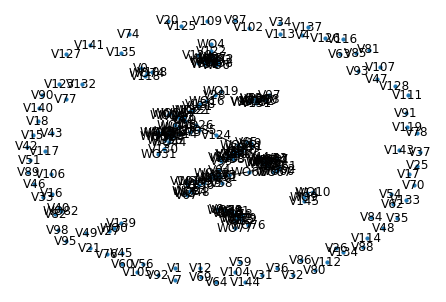

In [1042]:
# Draw Graph with nodes and edges with coordinates
G=nx.Graph()
for i,j in vacant_spaces.items():
    G.add_node(i)
G.add_edges_from(nearby_waste100)
nx.draw(G, with_labels=True, node_size=10)

# Create a dictionary with vacant spaces and waste outputs them
new_waste_dict = create_edge_dict(G)
waste_dict = {}
for i,k in new_waste_dict.items():
    if i in vacant_spaces:
        waste_dict[i]=k
        
#List of dictionaries we will use:
# print(v_potential)
# print(waste_dict)
# print(uf_systems)

# add needed inputs for each potential system into the v_potential dictionary
v_potential_dict={}
for i,k in v_potential.items():
    v_potential_dict[i]={}
    potential_systems = v_potential[i]["UF"]
    for item in potential_systems:
       v_potential_dict[i][item] = uf_systems[item]["in"]
        
#Design Rule 1.0 : Waste Availability
    #if there are more than 2 found items assign that system to that vacant space
    
    

Design Rule 3.0 : Sharing Existing Resources
    

Prepare Data

In [1043]:
# Preparation of Data
#Make a dictionary of found items nearby for each potential uf system
found_dict={}

for i,k in v_potential_dict.items():
    found_dict[i]={}
    for system,demanded in k.items():
        found_dict[i][system]={}
        found_dict[i][system]["found"]={}
        found_dict[i][system]["source"]={}
        found=[]
        source=[]
        for waste in waste_dict[i]:
            for each in demanded: 
                available = wastes[waste]["type"]
                source2 = wastes[waste]["tag"]
                print(i,wastes[waste])
                source_size = wastes[waste]["size"]
                if each == available:
                    found.append(available)
                    source.append(source2)
                    found_dict[i][system]["found"]=found
                    found_dict[i][system]["source"]=source


V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'was

In [1044]:

#Make a dictionary of missing for each potential uf system           
for i,system in found_dict.items():
    for uf in system:
        missing=[]
        found_dict[i][uf]["missing"]={}
        for x,y in uf_systems.items():
            for item in uf_systems[x]["in"]:
                if uf == x:
                    missing.append(item)
                    found_dict[i][uf]["missing"]=missing
        
#In the dictionary missing items also contain found items
for i,k in found_dict.items():
    for system in k:
        for item in (found_dict[i][system]["found"]):
            if item in found_dict[i][system]["missing"]:
                missing_list=found_dict[i][system]["missing"]
                missing_list.remove(item)

#reach sizes of duplicate items
for i,k in found_dict.items():
    for system in k:
        found_items=found_dict[i][system]["found"]

#Make a dictionary holding each vacant space& found and repeating waste type & waste sources corresponding to found items
duplicate_items={}
for space,potential in found_dict.items():
    duplicate_items[space]={}
    for system, k in potential.items():
        if len(found_dict[space][system]["found"])> 1:
            found_items3=found_dict[space][system]["found"]
            sources=[]
            for index,items in enumerate(found_items3):
                duplicate_items[space][items]={}
                count=found_items3.count(items)
                if count>1:
                    items_str=str(items)
                    sources.append(found_dict[space][system]["source"][index])
                    duplicate_items[space][items]["matching sources"]=sources

# check if the total size of found waste matches the vacant space size

satisfying_duplicate={}
not_enough_waste={}
for space, k in duplicate_items.items():
    print(space)
    satisfying_duplicate[space]={}
    not_enough_waste[space]={}
    for key,value in k.items():
        print(key)
        satisfying_duplicate[space][key]={}
        not_enough_waste[space][key]={}
        waste_matched=[]
        not_matched=[]
        if duplicate_items[space][key]!=[]:
            for m,n in duplicate_items[space][key].items():
                matched=duplicate_items[space][key][m]
                for items in matched:
                    found_new=[]
                    waste_matched.append(wastes[items]["size"])
                    if sum(waste_matched)==vacant_spaces[space]["size"]:
                        print(space,vacant_spaces[space]["size"], waste_matched, "add to found list and remove from missing")
                        found_new=(matched)
                        print(found_new, "is found")
                        satisfying_duplicate[space][key]=found_new
                    else:
                        # print(sum(waste_matched),"And",vacant_spaces[space]["size"],items)
                        not_matched.append(items)
                        print(not_matched,"is not matched")
                        not_enough_waste[space][key]=not_matched
                    
                    
print(satisfying_duplicate)
print(not_matched)

V0
V1
V2
W5
['WO41'] is not matched
['WO41', 'WO43'] is not matched
V2 3 [1, 1, 1] add to found list and remove from missing
['WO41', 'WO43', 'WO44', 'WO45', 'WO35'] is found
['WO41', 'WO43', 'WO45'] is not matched
['WO41', 'WO43', 'WO45', 'WO35'] is not matched
W6
V3
W6
W2
W3
W5
['WO7'] is not matched
['WO7', 'WO5'] is not matched
V3 3 [1, 1, 1] add to found list and remove from missing
['WO7', 'WO5', 'WO8', 'WO6'] is found
['WO7', 'WO5', 'WO6'] is not matched
V4
V5
W5
['WO51'] is not matched
['WO51', 'WO50'] is not matched
V6
V7
V8
W5
['WO26'] is not matched
['WO26', 'WO24'] is not matched
V8 3 [1, 1, 1] add to found list and remove from missing
['WO26', 'WO24', 'WO27', 'WO18'] is found
['WO26', 'WO24', 'WO18'] is not matched
V9
V10
V11
V12
V13
W5
['WO21'] is not matched
['WO21', 'WO38'] is not matched
V13 3 [1, 1, 1] add to found list and remove from missing
['WO21', 'WO38', 'WO22'] is found
V14
V15
V16
V17
V18
V19
V20
V21
V22
W5
['WO58'] is not matched
['WO58', 'WO55'] is not match

In [1045]:

#remove duplicate items if they are also in satisfying_duplicate items list
for space,potential in found_dict.items():
    for system in potential.keys():
        for key, value in satisfying_duplicate.items():
            for waste in value.keys():
                if key==space:
                        if len(found_dict[space][system]["found"])>0:
                            if len(satisfying_duplicate[key][waste])>0:
                                if waste in found_dict[space][system]["found"]:
                                    type(satisfying_duplicate[key][waste])
                                    found_items = found_dict[space][system]["found"]
                                    duplicate=list_duplicates(found_items)
                                    for found in found_items:
                                        if found in duplicate:
                                            found_items.remove(found)                                                
# print(found_dict)
#remove duplicate items if they are not in satisfying_duplicate items list
print(found_dict["V2"])
for space in found_dict.keys():
    for system in found_dict[space].keys():
        found_items = found_dict[space][system]["found"]
        missing_items = found_dict[space][system]["missing"]
        duplicate=list_duplicates(found_items)
        for key, value in satisfying_duplicate.items():
            for waste in value.keys():
                if key==space:
                    for found in found_items:
                        if found in duplicate:
                            print("duplicate",space,found,system)
                            if satisfying_duplicate[space][found]==[]:
                                print("duplicate not satisfying",space,found,system)
                                found_items.remove(found) 
                                if found not in missing_items:
                                    missing_items.append(found)
                                if (found in missing_items) and (found in found_items):
                                    found_items.remove(found)            
                                


{'UF4': {'found': ['W6', 'W5', 'W5'], 'source': ['WO41', 'WO43', 'WO37', 'WO44', 'WO45', 'WO35'], 'missing': ['W7']}, 'UF5': {'found': ['W6', 'W5', 'W5'], 'source': ['WO41', 'WO43', 'WO37', 'WO44', 'WO45', 'WO35'], 'missing': ['W7']}, 'UF9': {'found': ['W6', 'W5', 'W5'], 'source': ['WO41', 'WO43', 'WO37', 'WO44', 'WO45', 'WO35'], 'missing': ['W7']}}
duplicate V2 W5 UF4
duplicate V2 W5 UF4
duplicate V2 W5 UF4
duplicate V2 W5 UF4
duplicate V2 W5 UF5
duplicate V2 W5 UF5
duplicate V2 W5 UF5
duplicate V2 W5 UF5
duplicate V2 W5 UF9
duplicate V2 W5 UF9
duplicate V2 W5 UF9
duplicate V2 W5 UF9
duplicate V3 W5 UF8
duplicate V3 W5 UF8
duplicate V3 W5 UF8
duplicate V3 W5 UF8
duplicate V3 W5 UF8
duplicate V3 W5 UF8
duplicate V3 W5 UF8
duplicate V3 W5 UF8
duplicate V5 W5 UF4
duplicate V5 W5 UF4
duplicate V5 W5 UF5
duplicate V5 W5 UF5
duplicate V5 W5 UF7
duplicate V5 W5 UF7
duplicate V5 W5 UF9
duplicate V5 W5 UF9
duplicate V8 W5 UF4
duplicate V8 W5 UF4
duplicate V8 W5 UF5
duplicate V8 W5 UF5
duplicat

In [1046]:
for space in found_dict:
    for system in found_dict[space]:
        source=found_dict[space][system]["source"]
        for index,item in enumerate(source):
            waste=wastes[item]["type"]
            if waste in found_dict[space][system]["found"]:
                print("found",space,item,waste)
            else:
                source.remove(item)
                print(item,"removed from",space,system,waste)
 

found V2 WO41 W5
found V2 WO43 W5
found V2 WO37 W6
found V2 WO44 W5
found V2 WO45 W5
found V2 WO35 W5
found V2 WO41 W5
found V2 WO43 W5
found V2 WO37 W6
found V2 WO44 W5
found V2 WO45 W5
found V2 WO35 W5
found V2 WO41 W5
found V2 WO43 W5
found V2 WO37 W6
found V2 WO44 W5
found V2 WO45 W5
found V2 WO35 W5
found V3 WO42 W6
found V3 WO1 W2
found V3 WO3 W3
found V3 WO42 W6
found V3 WO7 W5
found V3 WO5 W5
found V3 WO8 W5
found V3 WO6 W5
found V5 WO51 W5
found V5 WO50 W5
found V5 WO51 W5
found V5 WO50 W5
found V5 WO51 W5
found V5 WO50 W5
found V5 WO51 W5
found V5 WO50 W5
found V8 WO26 W5
found V8 WO24 W5
found V8 WO27 W5
found V8 WO18 W5
found V8 WO26 W5
found V8 WO24 W5
found V8 WO27 W5
found V8 WO18 W5
found V8 WO26 W5
found V8 WO24 W5
found V8 WO27 W5
found V8 WO18 W5
found V9 WO80 W5
found V9 WO80 W5
found V9 WO80 W5
found V9 WO80 W5
found V13 WO21 W5
found V13 WO38 W5
found V13 WO22 W5
found V13 WO21 W5
found V13 WO38 W5
found V13 WO22 W5
found V13 WO21 W5
found V13 WO38 W5
found V13 WO

In [1047]:
        
print(found_dict["V2"])
print(wastes["WO43"]["size"],wastes["WO45"]["size"],wastes["WO37"]["size"])

{'UF4': {'found': ['W6', 'W5', 'W5'], 'source': ['WO41', 'WO43', 'WO37', 'WO44', 'WO45', 'WO35'], 'missing': ['W7']}, 'UF5': {'found': ['W6', 'W5', 'W5'], 'source': ['WO41', 'WO43', 'WO37', 'WO44', 'WO45', 'WO35'], 'missing': ['W7']}, 'UF9': {'found': ['W6', 'W5', 'W5'], 'source': ['WO41', 'WO43', 'WO37', 'WO44', 'WO45', 'WO35'], 'missing': ['W7']}}
1 1 3


In [1048]:
#add circularity percentage to found_dict
for space in found_dict:
    for system in found_dict[space]:
        found_dict[space][system]["circularity"]=[]
        found=len(found_dict[space][system]["found"])
        missing=len(found_dict[space][system]["missing"])
        total=found+missing
        found_dict[space][system]["circularity"]=found/total
# print(found_dict)   

#make a duplicate of found dict, sort system based on circularities
sorted_dict={}
for space in found_dict:
    system=sorted(found_dict[space], key=lambda x: (found_dict[space][x]['circularity']), reverse=True)  
    sorted_dict[space]={} 
    for item in system:
        values={}
        values=(found_dict[space][item])
        sorted_dict[space][item]=values

# print(sorted_dict)

Assign Food Production System To Vacant Space

In [1049]:
#check if the criteria is satisfied
occupied={}
used_waste=[]
used_waste_source=[]
used_waste_source_temp=[]
new_edges=[]
occupied_dict={}

for space in sorted_dict:
    print("looking for", space)
    print("for",space,sorted_dict[space],"is possible")
    occupied_dict[space]={}
    occupied_dict[space]["system"]={}
    occupied_dict[space]["found"]={}
    occupied_dict[space]["source"]={}
    occupied_dict[space]["missing"]={}
    for index,system in enumerate(sorted_dict[space]):
        print("looking for system", system)
        occupied[space]={}
        occupied[space]["system"]={}
        found_list=sorted_dict[space][system]["found"]
        sources_list=sorted_dict[space][system]["source"]
        missing_list=sorted_dict[space][system]["missing"]
        print(len(missing_list),"is length for",space,system)

        if len(occupied[space]["system"])==0:
            print(space,"is not occupied run for",system)
            if len(missing_list)==0:    
                for source in sources_list:
                    if source in used_waste_source:
                        print(used_waste_source,"is used",space,system)
                        pass
                    elif source not in used_waste_source:
                        print(used_waste_source,"is used",space,system)
                        occupied[space]["system"]=system
                        occupied_dict[space]["system"]=system
                        occupied_dict[space]["found"]=sorted_dict[space][system]["found"]
                        occupied_dict[space]["source"]=sorted_dict[space][system]["source"]
                        for items in found_list:
                            used_waste.append(items)
                        used_waste_source.append(source)
                        edge_tuple=(source,space)
                        new_edges.append(edge_tuple)
                        print("no missing items:", space, system, "assign")
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break
            elif len(missing_list)==1:
                print("one item",system,space)
                for missing in missing_list:
                    if missing in non_critical_items:
                        for source in sources_list:
                            if source not in used_waste_source:
                                print("Used Non Critical Source",source)
                                occupied[space]["system"]=system
                                occupied_dict[space]["system"]=system
                                occupied_dict[space]["found"]=sorted_dict[space][system]["found"]
                                occupied_dict[space]["source"]=sorted_dict[space][system]["source"]
                                occupied_dict[space]["missing"]=sorted_dict[space][system]["missing"]
                                for items in found_list:
                                    used_waste.append(items)
                                used_waste_source.append(source)
                                edge_tuple=(source,space)
                                new_edges.append(edge_tuple)
                                print("one non critical missing items:", space, system, "assign")
                    else:
                        print(space,"critical item missing:",missing,"for",system)
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break 
            elif len(missing_list)==2:
                print("two items",system,space)
                for missing in missing_list:
                    print("two items",missing)
                    if missing in non_critical_items:
                        print("two items",missing,"not critical")
                        for source in sources_list:
                            if source not in used_waste_source:
                                print("Used Non Critical Source",source)
                                occupied[space]["system"]=system
                                occupied_dict[space]["system"]=system
                                occupied_dict[space]["found"]=sorted_dict[space][system]["found"]
                                occupied_dict[space]["source"]=sorted_dict[space][system]["source"]
                                occupied_dict[space]["missing"]=sorted_dict[space][system]["missing"]
                                for items in found_list:
                                    used_waste.append(items)
                                print("two non critical missing items:", space, system,"assign")
                                print(space,occupied_dict[space])
                                used_waste_source.append(source)
                                edge_tuple=(source,space)
                                new_edges.append(edge_tuple)
                    else:
                        print(space,"critical item missing:",missing,"for",system)
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break  
for space in occupied_dict:
    if len(occupied_dict[space]["system"])!=0:
        print(space,occupied_dict[space]["system"])

looking for V0
for V0 {'UF4': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'circularity': 0.0}, 'UF5': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'circularity': 0.0}, 'UF6': {'found': {}, 'source': {}, 'missing': ['W6'], 'circularity': 0.0}, 'UF7': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'circularity': 0.0}, 'UF9': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'circularity': 0.0}} is possible
looking for system UF4
3 is length for V0 UF4
V0 is not occupied run for UF4
looking for system UF5
3 is length for V0 UF5
V0 is not occupied run for UF5
looking for system UF6
1 is length for V0 UF6
V0 is not occupied run for UF6
one item UF6 V0
looking for system UF7
3 is length for V0 UF7
V0 is not occupied run for UF7
looking for system UF9
3 is length for V0 UF9
V0 is not occupied run for UF9
looking for V1
for V1 {'UF4': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'circularity': 0.0}, 'UF5': {'found': {}, 'source': 

Create New List To Be Used In Next Steps

In [1050]:
# print(occupied)  
# print(used_waste_source) 
# print(new_edges)
# print(occupied_dict)
#add circularity & outputs to occupied_dict
for space in occupied_dict:
    occupied_dict[space]["circularity"]={}
    occupied_dict[space]["outputs"]={}
    occupied_dict[space]["supplements"]={}
    if len(occupied_dict[space]["system"])!=0:
        system=occupied_dict[space]["system"]
        outputs=(uf_systems[system]["out"])
        supplements=uf_systems[system]["supplement"]
        occupied_dict[space]["circularity"]=found_dict[space][system]["circularity"]
        occupied_dict[space]["supplements"]=supplements
        occupied_dict[space]["outputs"]=outputs

#remove empty spaces from occupied_dict
remove=[]
for space in occupied_dict:
    if len(occupied_dict[space]["system"])==0:
        remove.append(space)
for items in remove:
    occupied_dict.pop(items)
# print("occupied",occupied_dict)

#remove assigned spaces from found_dict
remove2=[]
for space in sorted_dict:
    if space in occupied_dict:
        remove2.append(space)
for items in remove2:
    sorted_dict.pop(items)
# print("non occupied",sorted_dict)

6. Assign Food Producing Supplementary Systems

Prepare Data

In [1051]:
#look for a system that can supply needed supplement
#put the findings in a dictionary
v_supplement_fs={}
for space in occupied_dict:
    v_supplement_fs[space]={}
    v_supplement_fs[space]["supplement"]={}
    v_supplement_fs[space]["fs_system"]={}
    v_supplement_fs[space]["supplement"]={}
    v_supplement_fs[space]["supplement source"]={}
    v_supplement_fs[space]["fs_demand"]={}
    v_supplement_fs[space]["fs_demand source"]={}
    v_supplement_fs[space]["potential source"]={}
    supplement=occupied_dict[space]["supplements"]
    if supplement!=None:
        for item in supplement:
            if item=="S2": 
                for i in uf_systems:
                    out=uf_systems[i]["out"]
                    if "S2" in out:
                        print("maybe",space, i,uf_systems[i]["in"])
                        v_supplement_fs[space]["fs_system"]=i
                        v_supplement_fs[space]["supplement"]=item
                        v_supplement_fs[space]["fs_demand"]=uf_systems[i]["in"]
    else:
        v_supplement_fs[space]["fs_system"]=None

print(v_supplement_fs)


maybe V2 UF2 ['W7']
maybe V3 UF2 ['W7']
maybe V5 UF2 ['W7']
maybe V8 UF2 ['W7']
maybe V9 UF2 ['W7']
maybe V13 UF2 ['W7']
maybe V22 UF2 ['W7']
maybe V24 UF2 ['W7']
maybe V27 UF2 ['W7']
maybe V28 UF2 ['W7']
maybe V40 UF2 ['W7']
maybe V44 UF2 ['W7']
maybe V52 UF2 ['W7']
maybe V66 UF2 ['W7']
maybe V75 UF2 ['W7']
maybe V97 UF2 ['W7']
maybe V142 UF2 ['W7']
{'V2': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V3': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V5': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V8': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V9': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_de

In [1052]:
#created a dictionary for spaces which need supplement to store system, supplementing neighbor and supplement type
#for each space found what kind of system and supplement and input is necessary 

#look neighbors of supplement needing space to see if there is a potential neighbor
for space in v_supplement_fs:
    potential=[]
    for space2,neighbor in nearby_space100:
        if space==space2:
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                # print(neighbor,"is available")
                system=v_supplement_fs[space]["fs_system"]
                print(system,"system")
                print(vacant_spaces[space]["size"],vacant_spaces[neighbor]["size"])
                if (vacant_spaces[space]["size"]==vacant_spaces[neighbor]["size"]) and (vacant_spaces[neighbor]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[neighbor]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(neighbor)
                    # print(space,potential)
                    v_supplement_fs[space]["potential source"]=potential
        elif space==neighbor:
                print(neighbor,space2,"reverse is available")
                if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                    print(space2,"is available")
                    system=v_supplement_fs[space]["fs_system"]
                    if (vacant_spaces[space]["size"]==vacant_spaces[space2]["size"]) and (vacant_spaces[space2]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[space2]["solar"]>=uf_systems[system]["solar"]):
                        potential.append(space2)
                        print(potential)
                        print(space,potential)
                        print(space,"matches",space2,"and",system)
                        v_supplement_fs[space]["potential source"]=potential
                    else:
                        print("structure",space,vacant_spaces[space2]["structure"],system,uf_systems[system]["weight"])
                        print("sun",space,vacant_spaces[space2]["solar"],system,uf_systems[system]["solar"])
                else:
                    print(space,space2,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")
# print(v_supplement_fs)


UF2 system
3 3
UF2 system
3 3
UF2 system
3 3
UF2 system
3 2
UF2 system
3 3
UF2 system
3 2
UF2 system
3 3
UF2 system
3 3
UF2 system
3 2
UF2 system
3 3
UF2 system
3 2
V13 V2 reverse is available
V2 is available
structure V13 1 UF2 3
sun V13 3 UF2 2
UF2 system
3 3
V24 V5 reverse is available
V5 is available
['V5']
V24 ['V5']
V24 matches V5 and UF2
UF2 system
3 2
UF2 system
3 2
UF2 system
3 3
UF2 system
3 1
UF2 system
3 1
UF2 system
3 1
UF2 system
3 2
UF2 system
3 2
UF2 system
3 2
UF2 system
3 1
UF2 system
3 2
V40 V36 reverse is available
V36 is available
structure V40 1 UF2 3
sun V40 3 UF2 2
UF2 system
3 1
UF2 system
3 3
V44 V1 reverse is available
V1 is available
['V1']
V44 ['V1']
V44 matches V1 and UF2
V44 V22 reverse is available
V22 is available
structure V44 1 UF2 3
sun V44 3 UF2 2
UF2 system
3 3
UF2 system
3 2
UF2 system
3 3
UF2 system
3 2
V66 V41 reverse is available
V41 is available
['V41']
V66 ['V41']
V66 matches V41 and UF2
V66 V52 reverse is available
V52 is available
structure

In [1053]:
#check if potential sources have fs_demand
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        # print(vacant,len(v_supplement_fs[space]["supplement source"]),"---",v_supplement_fs[space]["supplement source"])
        for vacant in potential:
            nearby_list=waste_dict[vacant]
            for nearby in nearby_list:
                print(vacant, nearby,"is",wastes[nearby]["type"])
                if nearby not in used_waste_source:
                    if wastes[nearby]["size"]==vacant_spaces[space]["size"]:
                        print(nearby,"not used")
                        if v_supplement_fs[space]["fs_demand"]==wastes[nearby]["type"]:
                            print("for",space,vacant,"is potential and has",nearby,"as a source of",wastes[nearby]["type"])
                            v_supplement_fs[space]["supplement source"]=vacant
                            print(v_supplement_fs[space]["supplement source"])
                            v_supplement_fs[space]["fs_demand source"]=nearby
                            print(v_supplement_fs[space]["fs_demand source"])
                            used_waste_source.append(nearby)
                            edge_tuple1=(nearby,vacant)
                            edge_tuple2=(vacant,space)
                            new_edges.append(edge_tuple1)
                            new_edges.append(edge_tuple2)
                            if len(v_supplement_fs[space]["supplement source"])>0:
                                # print(space,system,"will break")        
                                break

            if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break2")        
                            break
                    
# print(v_supplement_fs)  
# print(used_waste_source) 
# print(new_edges)     
print("occupied",occupied_dict)

for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            system=occupied_dict[occ]["system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
            occupied_dict[occ]["supplements"]=uf_systems[system]["supplement"]
print(occupied_dict)

#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["found"]
    
print(network_dict)
print(occupied_dict)
for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        print("work")
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            print(occupied_dict)
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
print(occupied_dict)

#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["found"]

print(network_dict)

#now we have food supplying supplementary systems
#we still need to check if these systems need supplements
for space in occupied_dict: 
    system=occupied_dict[space]["system"]
    # print(system)
    # print(uf_systems[system]["supplement"])
    value=uf_systems[system]["supplement"]
    for supplement in value:
        if (supplement=="S5") or (supplement=="S4"):
            v_supplement_fs[space]={}
            v_supplement_fs[space]["supplement"]=supplement
            for uf in uf_systems:
                for out in uf_systems[uf]["out"]:
                    if supplement == out:
                        v_supplement_fs[space]["fs_system"]=uf
                        v_supplement_fs[space]["fs_demand"]=uf_systems[uf]["in"]
            v_supplement_fs[space]["supplement source"]={}
            v_supplement_fs[space]["fs_demand source"]={}
            v_supplement_fs[space]["potential source"]={}
print(v_supplement_fs)


V23 WO44 is W5
V23 WO14 is W3
WO14 not used
V23 WO34 is W3
WO34 not used
V23 WO38 is W5
V23 WO36 is W1
V13 WO40 is W4
V13 WO17 is W1
V13 WO21 is W5
V13 WO38 is W5
V13 WO22 is W5
V5 WO53 is W3
WO53 not used
V5 WO51 is W5
V5 WO50 is W5
V5 WO66 is W3
WO66 not used
V53 WO54 is W1
V53 WO64 is W5
V53 WO57 is W5
V82 WO82 is W7
V66 WO78 is W4
V66 WO79 is W3
WO79 not used
V66 WO75 is W1
V66 WO77 is W5
V41 WO79 is W3
WO79 not used
V41 WO78 is W4
V41 WO75 is W1
V96 WO73 is W4
V120 WO68 is W5
V120 WO72 is W1
V120 WO73 is W4
occupied {'V2': {'system': 'UF4', 'found': ['W6', 'W5', 'W5'], 'source': ['WO41', 'WO43', 'WO37', 'WO44', 'WO45', 'WO35'], 'missing': ['W7'], 'circularity': 0.75, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V3': {'system': 'UF8', 'found': ['W6', 'W5', 'W5'], 'source': ['WO42', 'WO7', 'WO5', 'WO8', 'WO6'], 'missing': {}, 'circularity': 1.0, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V5': {'system': 'UF4', 'found': ['W5', 'W5'], 'source': ['WO51', 'WO50'], 'mis

In [1054]:
#make a potential list
for space in v_supplement_fs:
    potential=[]
    print(space)
    for space2,neighbor in nearby_space100:  
        if (space==space2):
            print(space2,neighbor)
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                print(neighbor,"is available")
                system=v_supplement_fs[space]["fs_system"]
                if (vacant_spaces[space]["size"]==vacant_spaces[neighbor]["size"]) and (vacant_spaces[neighbor]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[neighbor]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(neighbor)
                    print(potential)
                    print(space,potential)
                    v_supplement_fs[space]["potential source"]=potential
                else:
                    print(space,vacant_spaces[neighbor]["structure"],system,uf_systems[system]["weight"])
            else:
                print(space,neighbor,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")
        elif space==neighbor:
            print(neighbor,space2,"reverse is available")
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                print(space2,"is available")
                system=v_supplement_fs[space]["fs_system"]
                if (vacant_spaces[space]["size"]==vacant_spaces[space2]["size"]) and (vacant_spaces[space2]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[space2]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(space2)
                    print(potential)
                    print(space,potential)
                    print(space,"matches",space2,"and",system)
                    v_supplement_fs[space]["potential source"]=potential
                else:
                    print("structure",space,vacant_spaces[space2]["structure"],system,uf_systems[system]["weight"])
                    print("sun",space,vacant_spaces[space2]["solar"],system,uf_systems[system]["solar"])
                    print("size",vacant_spaces[space]["size"]==vacant_spaces[space2]["size"])
            else:
                print(space,space2,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")
print(v_supplement_fs)


V2
V2 V23
V23 is available
['V23']
V2 ['V23']
V2 V13
V13 is available
['V23', 'V13']
V2 ['V23', 'V13']
V3
V3 V68
V68 is available
V3 2 UF2 3
V3 V100
V100 is available
V3 3 UF2 3
V5
V5 V24
V24 is available
V5 1 UF2 3
V5 V94
V94 is available
V5 1 UF2 3
V8
V8 V79
V79 is available
V8 1 UF2 3
V8 V25
V25 is available
V8 1 UF2 3
V9
V9 V103
V103 is available
V9 1 UF2 3
V9 V72
V72 is available
V9 1 UF2 3
V9 V115
V115 is available
V9 1 UF2 3
V13
V13 V2 reverse is available
V2 is available
structure V13 1 UF2 3
sun V13 3 UF2 2
size True
V22
V22 V44
V44 is available
V22 1 UF2 3
V24
V24 V5 reverse is available
V5 is available
['V5']
V24 ['V5']
V24 matches V5 and UF2
V24 V94
V94 is available
V24 1 UF2 3
V24 V136
V136 is available
V24 1 UF2 3
V27
V27 V53
V53 is available
['V53']
V27 ['V53']
V27 V137
V137 is available
V27 3 UF2 3
V27 V139
V139 is available
V27 3 UF2 3
V27 V143
V143 is available
V27 3 UF2 3
V27 V119
V119 is available
V27 3 UF2 3
V27 V124
V124 is available
V27 3 UF2 3
V27 V98
V98 is ava

In [1055]:
#check if potential sources have fs_demand
print(used_waste_source)
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        for vacant in potential:
            found=[]
            found_source=[]
            nearby_list=waste_dict[vacant]
            for nearby in nearby_list:
                print(vacant, nearby,"is",wastes[nearby]["type"])
                if nearby not in used_waste_source:
                    if wastes[nearby]["size"]==vacant_spaces[space]["size"]:
                        print(nearby,"not used")
                        found.append(wastes[nearby]["type"])
                        found_source.append(nearby)
                        print(found)
                        if v_supplement_fs[space]["fs_demand"]==found:
                            print("for",space,vacant,"is potential and has",nearby,"as a source of",wastes[nearby]["type"])
                            v_supplement_fs[space]["supplement source"]=vacant
                            print(v_supplement_fs[space]["supplement source"])
                            v_supplement_fs[space]["fs_demand source"]=found_source
                            print(v_supplement_fs[space]["fs_demand source"])
                            for x in found_source:
                                used_waste_source.append(x)
                                edge_tuple1=(x,vacant)
                                new_edges.append(edge_tuple1)
                            edge_tuple2=(vacant,space)
                            new_edges.append(edge_tuple2)
                            print("new edges added",new_edges)
                            if len(v_supplement_fs[space]["supplement source"])>0:
                                # print(space,system,"will break")        
                                break

            if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break2")        
                            break
                    
print(v_supplement_fs) 
# print(new_edges)
# print(used_waste_source)

['WO41', 'WO43', 'WO37', 'WO44', 'WO45', 'WO35', 'WO42', 'WO7', 'WO5', 'WO8', 'WO6', 'WO51', 'WO50', 'WO26', 'WO24', 'WO27', 'WO18', 'WO80', 'WO21', 'WO38', 'WO22', 'WO58', 'WO55', 'WO64', 'WO61', 'WO57', 'WO63', 'WO60', 'WO62', 'WO67', 'WO59', 'WO52', 'WO49', 'WO0', 'WO19', 'WO82', 'WO56', 'WO81', 'WO77', 'WO85', 'WO68', 'WO76']
V23 WO44 is W5
V23 WO14 is W3
WO14 not used
['W3']
V23 WO34 is W3
WO34 not used
['W3', 'W3']
V23 WO38 is W5
V23 WO36 is W1
V13 WO40 is W4
V13 WO17 is W1
V13 WO21 is W5
V13 WO38 is W5
V13 WO22 is W5
V5 WO53 is W3
WO53 not used
['W3']
V5 WO51 is W5
V5 WO50 is W5
V5 WO66 is W3
WO66 not used
['W3', 'W3']
V53 WO54 is W1
V53 WO64 is W5
V53 WO57 is W5
V82 WO82 is W7
V66 WO78 is W4
V66 WO79 is W3
WO79 not used
['W3']
V66 WO75 is W1
V66 WO77 is W5
V41 WO79 is W3
WO79 not used
['W3']
V41 WO78 is W4
V41 WO75 is W1
V96 WO73 is W4
V120 WO68 is W5
V120 WO72 is W1
V120 WO73 is W4
{'V2': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'f

In [1056]:
print(occupied_dict)
for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            system=v_supplement_fs[space]["fs_system"]
            print(occ,system)
            print(len(uf_systems[system]))
            print(len(occupied_dict[occ]["found"]))
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
            occupied_dict[occ]["outputs"]=v_supplement_fs[space]["supplement"]
            occupied_dict[occ]["supplements"]=uf_systems[system]["supplement"]
            occupied_dict[occ]["circularity"]=1.0
print(occupied_dict)



{'V2': {'system': 'UF4', 'found': ['W6', 'W5', 'W5'], 'source': ['WO41', 'WO43', 'WO37', 'WO44', 'WO45', 'WO35'], 'missing': ['W7'], 'circularity': 0.75, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V3': {'system': 'UF8', 'found': ['W6', 'W5', 'W5'], 'source': ['WO42', 'WO7', 'WO5', 'WO8', 'WO6'], 'missing': {}, 'circularity': 1.0, 'outputs': ['O1', 'W1', 'W7'], 'supplements': ['S2']}, 'V5': {'system': 'UF4', 'found': ['W5', 'W5'], 'source': ['WO51', 'WO50'], 'missing': ['W6', 'W7'], 'circularity': 0.5, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V8': {'system': 'UF4', 'found': ['W5', 'W5'], 'source': ['WO26', 'WO24', 'WO27', 'WO18'], 'missing': ['W6', 'W7'], 'circularity': 0.5, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V9': {'system': 'UF4', 'found': ['W5'], 'source': ['WO80'], 'missing': ['W6', 'W7'], 'circularity': 0.3333333333333333, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V13': {'system': 'UF4', 'found': ['W5'], 'source': ['WO21', 'WO38', 'WO22'], 'mis

In [1057]:
#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["outputs"]
    
# print(network_dict)

for space in occupied_dict:
    if occupied_dict[space]["system"]==None:
        occupied_dict.remove(space)
print(new_edges)
print(network_dict)

[('WO41', 'V2'), ('WO43', 'V2'), ('WO37', 'V2'), ('WO44', 'V2'), ('WO45', 'V2'), ('WO35', 'V2'), ('WO42', 'V3'), ('WO7', 'V3'), ('WO5', 'V3'), ('WO8', 'V3'), ('WO6', 'V3'), ('WO51', 'V5'), ('WO50', 'V5'), ('WO26', 'V8'), ('WO24', 'V8'), ('WO27', 'V8'), ('WO18', 'V8'), ('WO80', 'V9'), ('WO21', 'V13'), ('WO38', 'V13'), ('WO22', 'V13'), ('WO58', 'V22'), ('WO55', 'V22'), ('WO64', 'V22'), ('WO61', 'V22'), ('WO57', 'V22'), ('WO63', 'V22'), ('WO60', 'V22'), ('WO62', 'V22'), ('WO67', 'V22'), ('WO59', 'V24'), ('WO52', 'V24'), ('WO49', 'V24'), ('WO0', 'V27'), ('WO19', 'V28'), ('WO82', 'V40'), ('WO56', 'V44'), ('WO81', 'V52'), ('WO77', 'V66'), ('WO85', 'V75'), ('WO68', 'V97'), ('WO76', 'V142')]
{'WO41': {'type': 'W5', 'size': 1, 'receiver': 'V2'}, 'WO43': {'type': 'W5', 'size': 1, 'receiver': 'V2'}, 'WO37': {'type': 'W6', 'size': 3, 'receiver': 'V2'}, 'WO44': {'type': 'W5', 'size': 1, 'receiver': 'V2'}, 'WO45': {'type': 'W5', 'size': 1, 'receiver': 'V2'}, 'WO35': {'type': 'W5', 'size': 1, 'receiv

In [1058]:
for space in occupied_dict:
    print(space,occupied_dict[space]["system"])

V2 UF4
V3 UF8
V5 UF4
V8 UF4
V9 UF4
V13 UF4
V22 UF4
V24 UF4
V27 UF4
V28 UF4
V40 UF4
V44 UF4
V52 UF4
V66 UF4
V75 UF4
V97 UF4
V142 UF4


Increasing Search Radius(nearby_waste200)
#make a dictionary of spaces and potential urban farming systems 


In [1059]:
#combine wastes and vacant_spaces
workbook = load_workbook(filename="coordintes_xyz.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

new_edges2=[]
for space in network_dict:
    sources=(network_dict[space]["receiver"])
    tuples=(space,sources)
    new_edges2.append(tuples)
print(new_edges2)

[('WO41', 'V2'), ('WO43', 'V2'), ('WO37', 'V2'), ('WO44', 'V2'), ('WO45', 'V2'), ('WO35', 'V2'), ('WO42', 'V3'), ('WO7', 'V3'), ('WO5', 'V3'), ('WO8', 'V3'), ('WO6', 'V3'), ('WO51', 'V5'), ('WO50', 'V5'), ('WO26', 'V8'), ('WO24', 'V8'), ('WO27', 'V8'), ('WO18', 'V8'), ('WO80', 'V9'), ('WO21', 'V13'), ('WO38', 'V13'), ('WO22', 'V13'), ('WO58', 'V22'), ('WO55', 'V22'), ('WO64', 'V22'), ('WO61', 'V22'), ('WO57', 'V22'), ('WO63', 'V22'), ('WO60', 'V22'), ('WO62', 'V22'), ('WO67', 'V22'), ('WO59', 'V24'), ('WO52', 'V24'), ('WO49', 'V24'), ('WO0', 'V27'), ('WO19', 'V28'), ('WO82', 'V40'), ('WO56', 'V44'), ('WO81', 'V52'), ('WO77', 'V66'), ('WO85', 'V75'), ('WO68', 'V97'), ('WO76', 'V142')]


In [1060]:
#update locations in dictionary based on excel worksheet
coordinate_list1=[]
for value in sheet1.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            coordinate=(value[0],value[1],value[2])
    coordinate_list1.append(coordinate)

for index1,space in enumerate(vacant_spaces):
    for index2,coordinate in enumerate(coordinate_list1):
        if index1==index2:
            vacant_spaces[space]["location"]=coordinate_list1[index2]


#update locations in dictionary based on excel worksheet

workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]
wastes2={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        wastes2[value[0]]={}
        wastes2[value[0]]["location"]=value[1]
        wastes2[value[0]]["source"]=value[2]
        wastes2[value[0]]["type"]=value[3]
        wastes2[value[0]]["quantity"]=value[4]
        wastes2[value[0]]["tag"]=value[5]
        wastes2[value[0]]["node_type"]="waste"


In [1061]:
#update locations in dictionary based on excel worksheet

workbook = load_workbook(filename="coordintes_xyz.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

coordinate_list2=[]
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            coordinate=(value[0],value[1],value[2])
    coordinate_list2.append(coordinate)

for index1,space in enumerate(wastes2):
    for index2,coordinate in enumerate(coordinate_list2): 
        if index1==index2:
            # print(index2,coordinate,space)
            wastes2[space]["location"]=coordinate_list2[index2]

combined_dict=vacant_spaces.copy()
combined_dict.update(wastes2)

coordinates=[]
#make a coordinate list for new_edges [(coordinates1,coordinates2),(coordinates1,coordinates2),(coordinates1,coordinates2)]
for item in new_edges2:
        # print(item)
        coordinate_tuple=(combined_dict[item[0]]["location"],combined_dict[item[1]]["location"])
        print(item,coordinate_tuple)
        coordinates.append(coordinate_tuple)

print(coordinates,"is coordinates")
print(new_edges2)


('WO41', 'V2') ((771.944204, 401.859102, 0), (766.997201, 400.341737, 0))
('WO43', 'V2') ((771.944204, 375.850679, 0), (766.997201, 400.341737, 0))
('WO37', 'V2') ((758.520502, 435.418358, 0), (766.997201, 400.341737, 0))
('WO44', 'V2') ((771.944204, 354.876145, 0), (766.997201, 400.341737, 0))
('WO45', 'V2') ((771.944204, 337.257536, 0), (766.997201, 400.341737, 0))
('WO35', 'V2') ((682.173196, 417.799749, 0), (766.997201, 400.341737, 0))
('WO42', 'V3') ((246.741859, 572.172323, 0), (254.491041, 556.132177, 0))
('WO7', 'V3') ((207.729225, 560.007093, 0), (254.491041, 556.132177, 0))
('WO5', 'V3') ((253.034219, 609.506994, 0), (254.491041, 556.132177, 0))
('WO8', 'V3') ((289.9494, 507.990247, 0), (254.491041, 556.132177, 0))
('WO6', 'V3') ((207.729225, 598.600236, 0), (254.491041, 556.132177, 0))
('WO51', 'V5') ((1141.934993, 436.257339, 0), (1189.499865, 487.345394, 0))
('WO50', 'V5') ((1110.053701, 436.257339, 0), (1189.499865, 487.345394, 0))
('WO26', 'V8') ((857.520305, 565.460472,

In [1062]:
export_edges_dict={}
for index,couple in enumerate(coordinates):
        export_edges_dict[index]={}
        export_edges_dict[index]["coordinate"]=couple

export_edges_dict={}
for index,waste in enumerate(network_dict):
        export_edges_dict[index]={}
        export_edges_dict[index]["type"]=network_dict[waste]["type"]
        export_edges_dict[index]["connection"]=coordinates[index]

print(export_edges_dict)

{0: {'type': 'W5', 'connection': ((771.944204, 401.859102, 0), (766.997201, 400.341737, 0))}, 1: {'type': 'W5', 'connection': ((771.944204, 375.850679, 0), (766.997201, 400.341737, 0))}, 2: {'type': 'W6', 'connection': ((758.520502, 435.418358, 0), (766.997201, 400.341737, 0))}, 3: {'type': 'W5', 'connection': ((771.944204, 354.876145, 0), (766.997201, 400.341737, 0))}, 4: {'type': 'W5', 'connection': ((771.944204, 337.257536, 0), (766.997201, 400.341737, 0))}, 5: {'type': 'W5', 'connection': ((682.173196, 417.799749, 0), (766.997201, 400.341737, 0))}, 6: {'type': 'W6', 'connection': ((246.741859, 572.172323, 0), (254.491041, 556.132177, 0))}, 7: {'type': 'W5', 'connection': ((207.729225, 560.007093, 0), (254.491041, 556.132177, 0))}, 8: {'type': 'W5', 'connection': ((253.034219, 609.506994, 0), (254.491041, 556.132177, 0))}, 9: {'type': 'W5', 'connection': ((289.9494, 507.990247, 0), (254.491041, 556.132177, 0))}, 10: {'type': 'W5', 'connection': ((207.729225, 598.600236, 0), (254.491

In [1063]:
#Make a dictionary of all spaces and systems
export_dict={}
for space in vacant_spaces:
    export_dict[space]={}
    export_dict[space]["location"]={}
    export_dict[space]["system"]={}
for space in vacant_spaces:
    if space in occupied_dict:
        export_dict[space]["system"]=occupied_dict[space]["system"]
        export_dict[space]["location"]=combined_dict[space]["location"]
    else:
        export_dict[space]["system"]=None
        export_dict[space]["location"]=None
print(export_dict)

{'V0': {'location': None, 'system': None}, 'V1': {'location': None, 'system': None}, 'V2': {'location': (766.997201, 400.341737, 0), 'system': 'UF4'}, 'V3': {'location': (254.491041, 556.132177, 0), 'system': 'UF8'}, 'V4': {'location': None, 'system': None}, 'V5': {'location': (1189.499865, 487.345394, 0), 'system': 'UF4'}, 'V6': {'location': None, 'system': None}, 'V7': {'location': None, 'system': None}, 'V8': {'location': (826.49752, 584.987928, 0), 'system': 'UF4'}, 'V9': {'location': (1886.407729, 148.985643, 0), 'system': 'UF4'}, 'V10': {'location': None, 'system': None}, 'V11': {'location': None, 'system': None}, 'V12': {'location': None, 'system': None}, 'V13': {'location': (725.481226, 475.783652, 0), 'system': 'UF4'}, 'V14': {'location': None, 'system': None}, 'V15': {'location': None, 'system': None}, 'V16': {'location': None, 'system': None}, 'V17': {'location': None, 'system': None}, 'V18': {'location': None, 'system': None}, 'V19': {'location': None, 'system': None}, 'V20

In [1064]:
file = "occupied nodes.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(export_dict, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "new_edges.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(new_edges, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "new_edges_dict.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(export_edges_dict, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")        

file = "coordinates.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(coordinates, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

occupied nodes.txt has been updated successfully
new_edges.txt has been updated successfully
new_edges_dict.txt has been updated successfully
coordinates.txt has been updated successfully


8. INCREASING RADIUS